In [36]:
!mkdir data

mkdir: cannot create directory ‘data’: File exists


In [37]:
!nvidia-smi

Fri May 17 14:53:58 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   59C    P0              29W /  70W |    345MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [38]:
# importing libraries
import time

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme('notebook')

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F

# Hyperparams
BATCH_SIZE = 64
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Transforms
train_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()
])

# Loading the dataset
dataset = torchvision.datasets.MNIST(root="data", train=True, download=True, transform=train_transform)
classes = dataset.classes

# select the first 1000 images
# dataset = torch.utils.data.Subset(dataset, range(len(dataset)//6))

train_dataset, val_dataset = torch.utils.data.random_split(dataset, [0.8, 0.2])
train_dataloader =  torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)

print(f"Dataset Loaded: {len(dataset)} images")
print(f"Train Dataloader: {len(train_dataloader)} batches({BATCH_SIZE})")
print(f"Validation Dataloader: {len(val_dataloader)} batches({BATCH_SIZE})")


Dataset Loaded: 60000 images
Train Dataloader: 750 batches(64)
Validation Dataloader: 188 batches(64)


In [39]:
# # print one image
# image, label = dataset[0]
# print(f"Image Shape: {image.shape}")
# print(f"Label: {label}")
# print(image)

Shape of one batch: torch.Size([64, 1, 28, 28]), torch.Size([64])


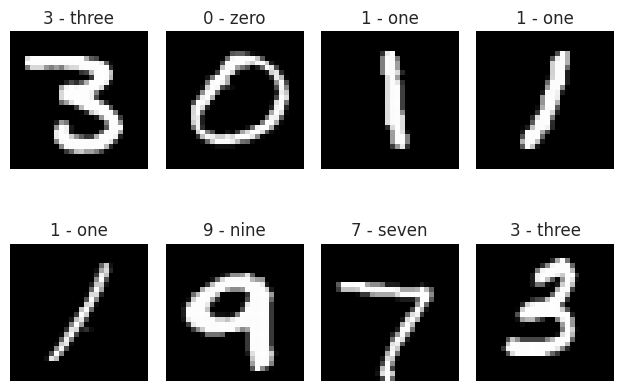

In [40]:
# Display a batch
X, y = next(iter(train_dataloader))
print(f"Shape of one batch: {X.shape}, {y.shape}")
fig, axs = plt.subplots(2, 4)
for idx, ax in enumerate(axs.flatten()):
    ax.set_axis_off()
    ax.set_title(classes[y[idx]])
    ax.imshow(X[idx].permute(1, 2, 0), cmap='gray')
fig.tight_layout()
plt.show()

In [41]:
# Model
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        return x

In [42]:
def train(model, dataloader, optimizer:torch.optim.Adam, epoch):
    model.train()
    loss_history = []
    for batch_idx, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        # X = X.reshape(-1, X.shape[2]*X.shape[3]) #flatten for MLP
        output = model(X)
        loss = F.cross_entropy(output, y)
        loss_history.append(loss.detach().cpu().numpy())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_idx%200 == 0:
            print(f"batch_idx: {batch_idx:<4} | train loss: {loss:.4f}")

    return loss_history


def eval(model, dataloader):
    model.eval()
    loss = 0
    acc = 0
    with torch.no_grad():
        for batch_idx, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)
            # X = X.reshape(-1, X.shape[2]*X.shape[3])
            output = model(X)
            loss += F.cross_entropy(output, y)

            #TODO: calculate accuracy
            acc += (output.argmax(dim=1) == y).float().mean()

    acc /= len(dataloader)
    loss /= len(dataloader)
    print(f"validation loss: {loss:.4f} | accuracy: {acc:.4f}")
    return loss.detach().cpu().numpy(), acc.detach().cpu().numpy()

In [43]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [44]:
from torch.optim.lr_scheduler import StepLR

EPOCHS = 10

model = CNN()
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=2e-3)
scheduler = StepLR(optimizer, step_size=3)

print(f"Model Parameters: {count_parameters(model):,}")

print("Starting Training...")
train_loss_history_global = []
valid_loss_history_global = []
valid_acc_history_global = []
for epoch in range(EPOCHS):
    print(f"Epoch {epoch+1}")
    train_loss_history = train(model, train_dataloader, optimizer, epoch)
    train_loss_history_global.extend(train_loss_history)
    valid_loss, valid_acc = eval(model, val_dataloader)
    valid_loss_history_global.append(valid_loss)
    valid_acc_history_global.append(valid_acc)
    scheduler.step()
    print()

Model Parameters: 1,199,882
Starting Training...
Epoch 1
batch_idx: 0    | train loss: 2.3055
batch_idx: 200  | train loss: 0.3737
batch_idx: 400  | train loss: 0.2219
batch_idx: 600  | train loss: 0.1515
validation loss: 0.0700 | accuracy: 0.9760

Epoch 2
batch_idx: 0    | train loss: 0.0968
batch_idx: 200  | train loss: 0.0188
batch_idx: 400  | train loss: 0.1121
batch_idx: 600  | train loss: 0.1581
validation loss: 0.0611 | accuracy: 0.9805

Epoch 3
batch_idx: 0    | train loss: 0.1883
batch_idx: 200  | train loss: 0.1901
batch_idx: 400  | train loss: 0.1725
batch_idx: 600  | train loss: 0.0588
validation loss: 0.0553 | accuracy: 0.9835

Epoch 4
batch_idx: 0    | train loss: 0.0999
batch_idx: 200  | train loss: 0.0989
batch_idx: 400  | train loss: 0.0045
batch_idx: 600  | train loss: 0.0218
validation loss: 0.0363 | accuracy: 0.9888

Epoch 5
batch_idx: 0    | train loss: 0.1041
batch_idx: 200  | train loss: 0.0181
batch_idx: 400  | train loss: 0.0284
batch_idx: 600  | train loss: 0.

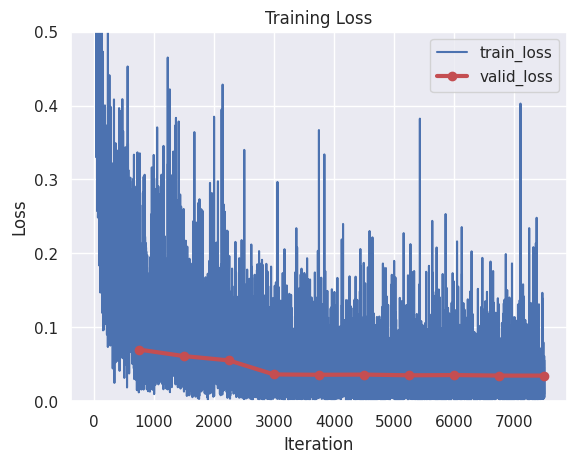

<Figure size 640x480 with 0 Axes>

In [45]:
plt.plot(train_loss_history_global, label="train_loss")
plt.plot([(i+1)*len(train_dataloader) for i in range(EPOCHS)], valid_loss_history_global, label="valid_loss", marker='o', color='r', linewidth=3)
plt.legend()
plt.ylabel("Loss")
plt.xlabel("Iteration")
plt.title("Training Loss")
plt.ylim(0, 0.5)
plt.show()
plt.savefig("cnn_loss.png")

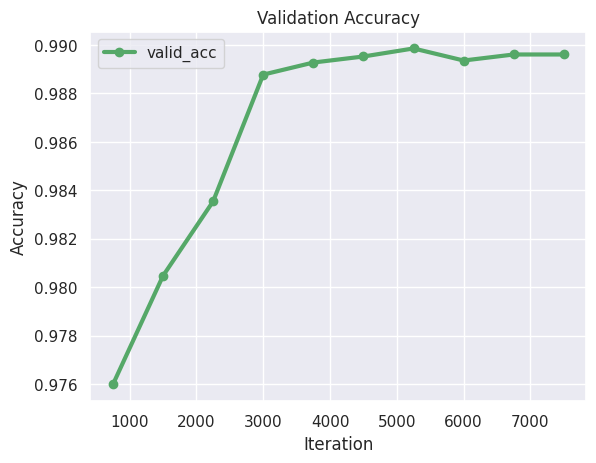

<Figure size 640x480 with 0 Axes>

In [46]:
plt.plot([(i+1)*len(train_dataloader) for i in range(EPOCHS)], valid_acc_history_global, label="valid_acc", marker='o', color='g', linewidth=3)
plt.legend()
plt.ylabel("Accuracy")
plt.xlabel("Iteration")
plt.title("Validation Accuracy")
plt.show()
plt.savefig("cnn_accuracy.png")

In [47]:
# Save the model
torch.save(model.state_dict(), "cnn_model.pth")
print("Model saved!")

# Load the model
# model = MLP()
# model.load_state_dict(torch.load("mlp_model.pth"))

Model saved!


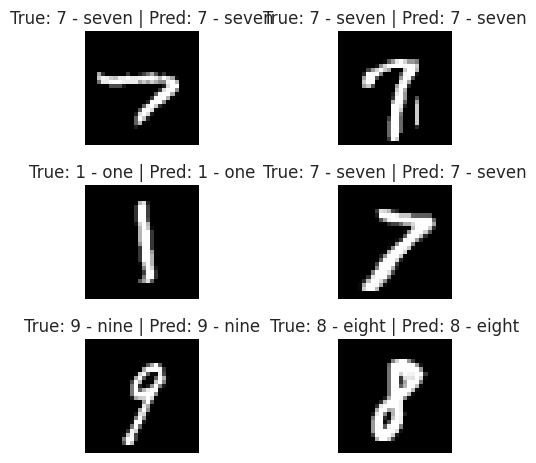

In [49]:
# Inference
for i in range(1):
    X, y = next(iter(val_dataloader))
    X, y = X.to(device), y.to(device)
    # X = X.reshape(-1, X.shape[2]*X.shape[3])
    output = model(X)
    pred = output.argmax(dim=1)
    fig, axs = plt.subplots(3, 2)
    for idx, ax in enumerate(axs.flatten()):
        ax.set_axis_off()
        ax.set_title(f"True: {classes[y[idx]]} | Pred: {classes[pred[idx]]}")
        ax.imshow(X[idx].reshape(28, 28).cpu().numpy(), cmap='gray')
    fig.tight_layout()
    plt.show()
    time.sleep(1)

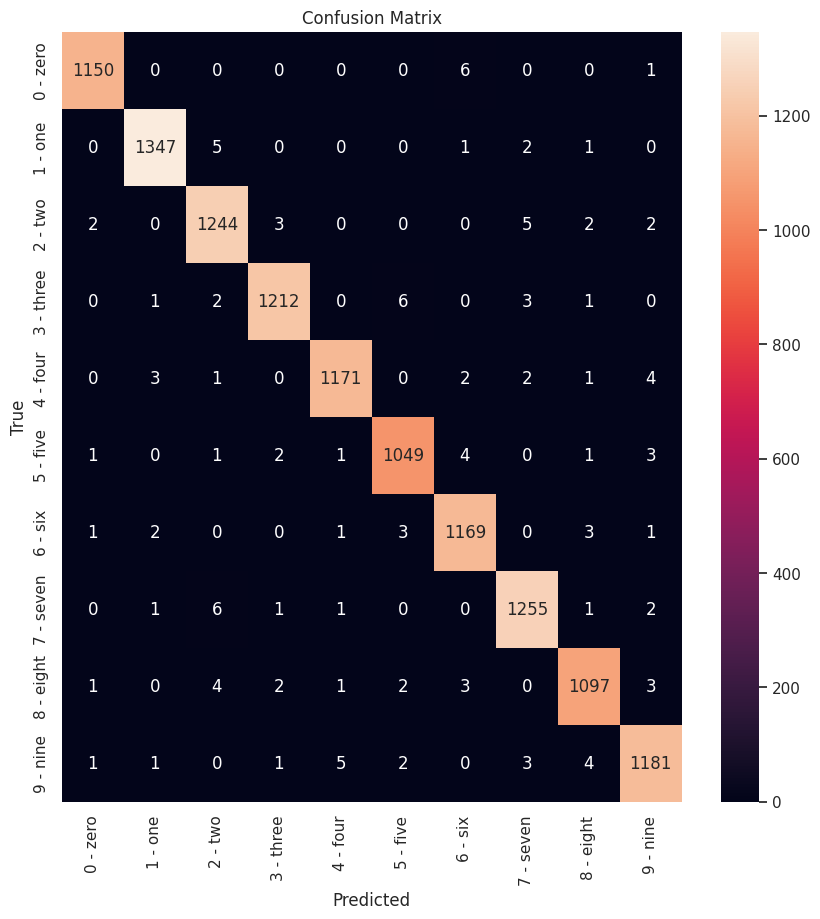

In [51]:
# confusion matrix
from sklearn.metrics import confusion_matrix
y_true = []
y_pred = []

model.eval()
with torch.no_grad():
    for batch_idx, (X, y) in enumerate(val_dataloader):
        X, y = X.to(device), y.to(device)
        # X = X.reshape(-1, X.shape[2]*X.shape[3])
        output = model(X)
        y_true.extend(y.cpu().numpy())
        y_pred.extend(output.argmax(dim=1).cpu().numpy())

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
